Found cached dataset parquet (C:/Users/HououinKyouma/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

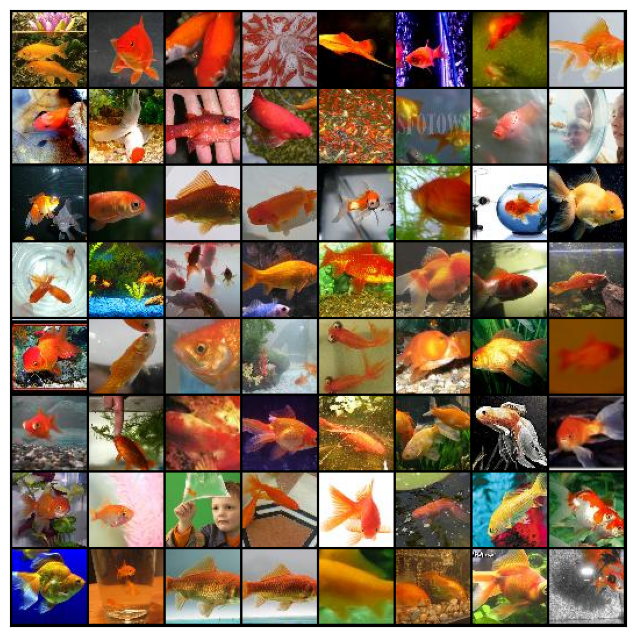

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config

batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  figure, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    images = images.detach()[:64]

    show_images(denormalize(images))
    break

show_batch(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


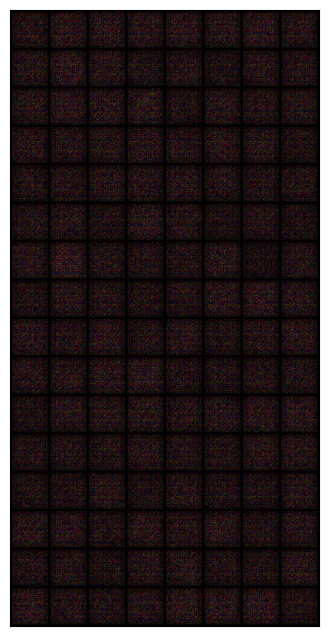

In [3]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights
from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [0]:
def save_samples(index, noises, show=True):
  images = generator(noises)

  filename = f'output-images-{index:0=4d}.png'
  save_image(denormalize(images), os.path.join(output_directory, filename), nrow=8)
  print(f'Saving {filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1, 2, 0))

def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_loss = F.binary_cross_entropy(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_predictions = discriminator(noises_images)
  noises_loss = F.binary_cross_entropy(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []


  optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images_images, _ in tqdm(dataloader):
      images_images = images_images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images_images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores

learning_rate = 0.0002
epochs = 400

output_directory = 'generated'
os.makedirs(output_directory, exist_ok=True)
constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, constant_noise)

history = fit(
  discriminator,
  generator,
  dataloader,
  epochs=epochs,
  learning_rate=learning_rate
)
losses_generator, losses_discriminator, image_scores, noise_scores = history

In [ ]:
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')

In [ ]:
generator.load_state_dict(torch.load('generator.pt'))
discriminator.load_state_dict(torch.load('discriminator.pt'))